In [ ]:
pip install pyswmm

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.1/531.1 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 14.6 MB/s eta 0:00:00
  Created wheel for julian: filename=julian-0.14-py3-none-any.whl size=2613 sha256=35fa89232d53fa290af2b03e9a1082c23604f2a610f4f0ae14d99b4ea9dfbf22
  Stored in directory: /root/.cache/pip/wheels/6b/8b/6f/f2610e040b0950d56996c5bfb542e53dbf58e0d99b2a14814c
Successfully built julian


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

prefix_path = "/content/drive/MyDrive/SWMM/"

Mounted at /content/drive/


In [ ]:
#GET OVERFLOW TIME CSV

from pyswmm import Output, NodeSeries

paths = ["2YR", "5YR", "10YR", "15YR", "20YR", "25YR", "50YR", "100YR"]

for path in paths:
  out_path = f"{prefix_path}Mandaue_Drainage_Network_{path}.out"
  records = []
  with Output(out_path) as out:
      node_series = NodeSeries(out)

      for node_id in list(out.nodes):
          node_data = node_series[node_id]
          flooding_ts = node_data.flooding_losses  # m3/s overflow indicator

          # Convert to DataFrame
          df = pd.DataFrame(list(flooding_ts.items()), columns=["time", "flooding_m3s"])
          if df.empty:
              records.append({"Node_ID": node_id, "Time_After_Raining_min": 0})
              continue

          # use first timestamp as t=0
          sim_start = df["time"].iloc[0]

          # Find first overflow time
          first_overflow = df[df["flooding_m3s"] > 0]
          if not first_overflow.empty:
              overflow_time = first_overflow.iloc[0]["time"]
              minutes_after_rain = round((overflow_time - sim_start).total_seconds() / 60, 2)
          else:
              minutes_after_rain = 60  # no overflow

          records.append({
              "YR": path,
              "Node_ID": node_id,
              "Time_After_Raining_min": minutes_after_rain
          })

  # Combine results
  overflow_df = pd.DataFrame(records)
  overflow_df = overflow_df.sort_values("Time_After_Raining_min").reset_index(drop=True)

  print(overflow_df)
  overflow_df.to_csv(f"{prefix_path}overflow_times_{path}.csv", index=False)
  print("✅ Saved overflow times to overflow_times.csv")


       YR  Node_ID  Time_After_Raining_min
0     2YR  ISD-586                   24.28
1     2YR    I-142                   24.40
2     2YR  ISD-538                   24.87
3     2YR  ISD-488                   24.95
4     2YR    I-138                   25.03
...   ...      ...                     ...
1408  2YR     O-40                   60.00
1409  2YR     O-41                   60.00
1410  2YR     O-42                   60.00
1411  2YR     O-43                   60.00
1412  2YR      I-0                   60.00

[1413 rows x 3 columns]
✅ Saved overflow times to overflow_times.csv
       YR  Node_ID  Time_After_Raining_min
0     5YR  ISD-533                   21.18
1     5YR  ISD-586                   21.50
2     5YR    I-142                   21.53
3     5YR  ISD-477                   21.87
4     5YR  ISD-478                   21.88
...   ...      ...                     ...
1408  5YR     O-40                   60.00
1409  5YR     O-41                   60.00
1410  5YR     O-42         

In [ ]:
#GET NODE FLOODING SUMMARY CSV

import csv
import re

def parse_rpt_to_csv(rpt_file_path, csv_file_path, path):
    """
    Convert Node Flooding Summary from RPT file to CSV format.

    Args:
        rpt_file_path: Path to the input .rpt file
        csv_file_path: Path to the output .csv file
    """

    # Read the RPT file
    with open(rpt_file_path, 'r') as file:
        content = file.read()

    lines = content.split('\n')

    # Find the Node Flooding Summary section
    start_idx = None
    header_idx = None
    dash_count = 0

    for i, line in enumerate(lines):
        if 'Node Flooding Summary' in line:
            start_idx = i
            print(f"Found 'Node Flooding Summary' at line {i}")

        if start_idx is not None and '----------' in line:
            dash_count += 1
            if dash_count == 2:  # Second dash line marks start of data
                header_idx = i + 1
                print(f"Data should start at line {header_idx}")
                break

    if start_idx is None:
        print("Error: Node Flooding Summary section not found in the file.")
        return

    if header_idx is None:
        print("Error: Could not find data section (dashed lines).")
        return

    # Extract data rows
    data_rows = []
    for i in range(header_idx, len(lines)):
        line = lines[i].strip()

        # Stop if we hit empty lines, another section, or dashes
        if not line:
            continue
        if line.startswith('*') or (line.startswith('-') and len(line) > 10):
            break

        # Parse the line - split by whitespace
        parts = line.split()

        # Debug: show what we're parsing
        if len(parts) < 6:
            print(f"Skipping line with {len(parts)} parts: {parts}")
            continue

        # Extract data (handle any number of parts < 6)
        node = parts[0]
        hours_flooded = float(parts[1])
        max_rate = float(parts[2])
        time_day = int(parts[3])

        # Convert "00:55" to decimal hours
        h, m = map(int, parts[4].split(':'))
        time_hour = m

        flood_volume = float(parts[5])

        data_rows.append({
            'YR': path,
            'Node': node,
            'Hours Flooded': hours_flooded,
            'Maximum Rate (CMS)': max_rate,
            'Time of Max (days)': time_day,
            'Time of Max (hr:min)': time_hour,
            'Total Flood Volume (10^6 ltr)': flood_volume,
        })

    # Write to CSV
    if data_rows:
        with open(csv_file_path, 'w', newline='') as csvfile:
            fieldnames = [
                'YR',
                'Node',
                'Hours Flooded',
                'Maximum Rate (CMS)',
                'Time of Max (days)',
                'Time of Max (hr:min)',
                'Total Flood Volume (10^6 ltr)',
            ]
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            writer.writeheader()
            writer.writerows(data_rows)

        print(f"\n✓ Successfully converted {len(data_rows)} rows to {csv_file_path}")
    else:
        print("\nError: No data rows found to convert.")
        print("Please check if the file format matches the expected structure.")

paths = ["2YR", "5YR", "10YR", "15YR", "20YR", "25YR", "50YR", "100YR"]
for path in paths:
  input_rpt = f"{prefix_path}Mandaue_Drainage_Network_{path}.rpt"
  output_csv = f"{prefix_path}node_flooding_summary_{path}.csv"

  parse_rpt_to_csv(input_rpt, output_csv, path)

Found 'Node Flooding Summary' at line 5364
Data should start at line 5374

✓ Successfully converted 394 rows to /content/drive/MyDrive/SWMM/node_flooding_summary_2YR.csv
Found 'Node Flooding Summary' at line 5501
Data should start at line 5511

✓ Successfully converted 531 rows to /content/drive/MyDrive/SWMM/node_flooding_summary_5YR.csv
Found 'Node Flooding Summary' at line 5541
Data should start at line 5551

✓ Successfully converted 663 rows to /content/drive/MyDrive/SWMM/node_flooding_summary_10YR.csv
Found 'Node Flooding Summary' at line 5567
Data should start at line 5577

✓ Successfully converted 689 rows to /content/drive/MyDrive/SWMM/node_flooding_summary_15YR.csv
Found 'Node Flooding Summary' at line 5589
Data should start at line 5599

✓ Successfully converted 690 rows to /content/drive/MyDrive/SWMM/node_flooding_summary_20YR.csv
Found 'Node Flooding Summary' at line 5605
Data should start at line 5615

✓ Successfully converted 711 rows to /content/drive/MyDrive/SWMM/node_fl

In [ ]:
#MERGE OVERFLOW_TIME + NODE FLOODING SUMMARY

paths = ["2YR", "5YR", "10YR", "15YR", "20YR", "25YR", "50YR", "100YR"]
for path in paths:
  # Read the CSV files
  df1 = pd.read_csv(f"{prefix_path}node_flooding_summary_{path}.csv") # contains Node, Hours Flooded, etc.
  df2 = pd.read_csv(f"{prefix_path}overflow_times_{path}.csv")        # contains Node_ID, Time_After_Raining_min

  # Merge them by matching Node ↔ Node_ID
  merged = pd.merge(df1, df2, left_on="Node", right_on="Node_ID", how="outer")
  merged = merged.drop(columns=["Node"])
  merged = merged.drop(columns=["YR_x"])
  merged = merged.rename(columns={"YR_y": "YR"})
  merged = merged.fillna(0)
  merged = merged[["Node_ID", "YR", "Time_After_Raining_min", "Hours Flooded",	"Maximum Rate (CMS)",
                   "Time of Max (days)", "Time of Max (hr:min)",	"Total Flood Volume (10^6 ltr)"]]

  # Sort rows by Node for consistency (optional)
  merged = merged.sort_values(by="Node_ID")
  # Save to new CSV
  merged.to_csv(f"{prefix_path}merged_output_{path}.csv", index=False)


In [ ]:
#Aggregate all outputs

# Read all CSVs
dfs = [
    pd.read_csv(f"{prefix_path}merged_output_2YR.csv"),
    pd.read_csv(f"{prefix_path}merged_output_5YR.csv"),
    pd.read_csv(f"{prefix_path}merged_output_10YR.csv"),
    pd.read_csv(f"{prefix_path}merged_output_15YR.csv"),
    pd.read_csv(f"{prefix_path}merged_output_20YR.csv"),
    pd.read_csv(f"{prefix_path}merged_output_25YR.csv"),
    pd.read_csv(f"{prefix_path}merged_output_50YR.csv"),
    pd.read_csv(f"{prefix_path}merged_output_100YR.csv")
]

# Combine them all
merged = pd.concat(dfs, ignore_index=True)

# Optional: sort or drop duplicates
merged = merged.sort_values(by=["Node_ID", "YR"])
# merged = merged.drop_duplicates()

# Save to CSV
merged.to_csv(f"{prefix_path}final_aggregated_output.csv", index=False)

In [ ]:
df = pd.read_csv(f"{prefix_path}final_aggregated_output.csv")
df.head()

,Node_ID,YR,Time_After_Raining_min,Hours Flooded,Maximum Rate (CMS),Time of Max (days),Time of Max (hr:min),Total Flood Volume (10^6 ltr)
0,I-0,100YR,60.0,0.0,0.0,0.0,0.0,0.0
1,I-0,10YR,60.0,0.0,0.0,0.0,0.0,0.0
2,I-0,15YR,60.0,0.0,0.0,0.0,0.0,0.0
3,I-0,20YR,60.0,0.0,0.0,0.0,0.0,0.0
4,I-0,25YR,60.0,0.0,0.0,0.0,0.0,0.0


Original: [[60.  0.  0.  0.  0.]
 [60.  0.  0.  0.  0.]
 [60.  0.  0.  0.  0.]
 ...
 [60.  0.  0.  0.  0.]
 [60.  0.  0.  0.  0.]
 [60.  0.  0.  0.  0.]]
Scaled: [[ 0.8486709  -0.41578329 -0.3854491  -0.88275833 -0.18936439]
 [ 0.8486709  -0.41578329 -0.3854491  -0.88275833 -0.18936439]
 [ 0.8486709  -0.41578329 -0.3854491  -0.88275833 -0.18936439]
 ...
 [ 0.8486709  -0.41578329 -0.3854491  -0.88275833 -0.18936439]
 [ 0.8486709  -0.41578329 -0.3854491  -0.88275833 -0.18936439]
 [ 0.8486709  -0.41578329 -0.3854491  -0.88275833 -0.18936439]]


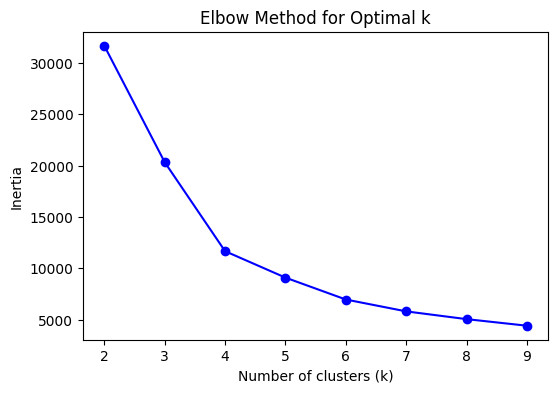

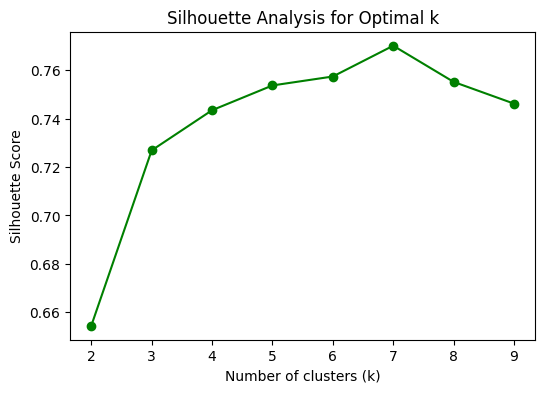

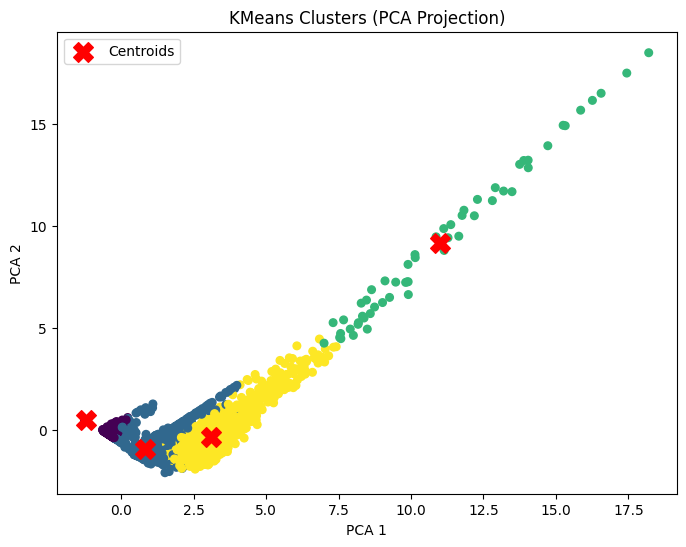

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


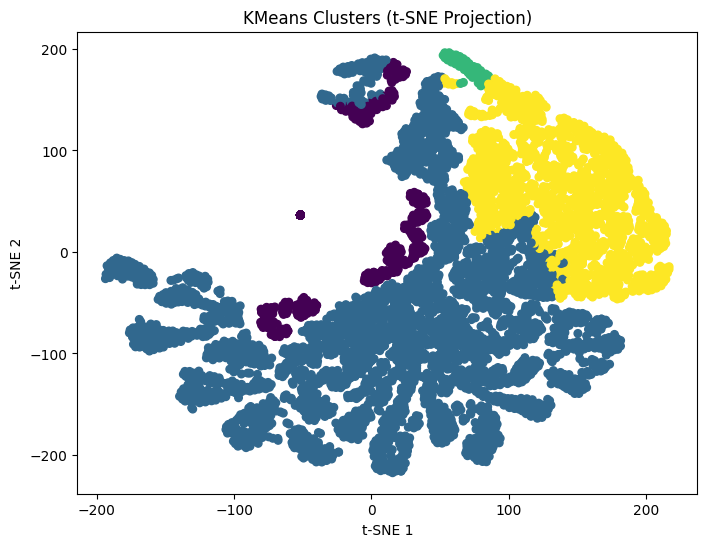

In [ ]:
features = ["Time_After_Raining_min", "Hours Flooded",	"Maximum Rate (CMS)",
            "Time of Max (hr:min)",	"Total Flood Volume (10^6 ltr)"]

X = df[features].values

# ===============================
# 2. Normalize Data
# ===============================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Original:", X)
print("Scaled:", X_scaled)

# ===============================
# 3. Elbow Method (Inertia)
# ===============================
inertia = []
K = range(2, 10)  # start from 2, since k=1 silhouette is undefined
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# ===============================
# 4. Silhouette Scores
# ===============================
silhouette_scores = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(K, silhouette_scores, 'go-')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for Optimal k")
plt.show()

# ===============================
# 5. Fit Final KMeans with chosen k
# ===============================
optimal_k = 4   # <-- choose based on elbow + silhouette
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to the original DataFrame
df['Cluster'] = labels

# ===============================
# 6. PCA Projection
# ===============================
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
centers_pca = pca.transform(kmeans.cluster_centers_)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=30)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', s=200, marker='X', label='Centroids')
plt.title("KMeans Clusters (PCA Projection)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.show()

# ===============================
# 7. t-SNE Projection
# ===============================
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=30)
plt.title("KMeans Clusters (t-SNE Projection)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [ ]:
import numpy as np
from collections import Counter

# Get centroids
centroids = kmeans.cluster_centers_

print(centroids)

# Weights based on vulnerability importance
weights = np.array([
    -0.20,  # Time_After_Raining_min: EARLIER flood = MORE vulnerable (negative)
    +0.25,  # Hours Flooded: LONGER duration = MORE vulnerable (positive)
    +0.30,  # Maximum Rate: HIGHER rate = MORE vulnerable (positive)
    -0.10,  # Time of Max: EARLIER peak = MORE vulnerable (negative)
    +0.15   # Total Flood Volume: LARGER volume = MORE vulnerable (positive)
])

# Compute vulnerability score per cluster
scores = np.dot(centroids, weights)

# Rank clusters by this score (low → high vulnerability)
order = np.argsort(scores)
cluster_ranking = {old: new for new, old in enumerate(order)}

# Category labels
categories = ["No risk" ,"Low", "Medium", "High"]

# Count nodes in each cluster
cluster_counts = Counter(kmeans.labels_)

print("\n" + "="*60)
print("CLUSTER DISTRIBUTION")
print("="*60)
for i in range(4):
    count = cluster_counts[i]
    ranked = cluster_ranking[i]
    category = categories[ranked]
    score = scores[i]
    print(f"Cluster {i} → Rank: {ranked} ({category}) | Nodes: {count} | Score: {score:.3f}")

print("\n" + "="*60)
print("VULNERABILITY CATEGORY SUMMARY")
print("="*60)
for rank, category in enumerate(categories):
    # Find which original cluster corresponds to this rank
    original_cluster = [k for k, v in cluster_ranking.items() if v == rank][0]
    count = cluster_counts[original_cluster]
    score = scores[original_cluster]
    print(f"{category} Vulnerability: {count} nodes (Score: {score:.3f})")

# Example new point
new_point = [[29.55, 0.51, 0.288, 55, 0.379]]
new_point_scaled = scaler.transform(new_point)

cluster_label = kmeans.predict(new_point_scaled)[0]
ranked_label = cluster_ranking[cluster_label]
final_category = categories[ranked_label]

print("\n" + "="*60)
print("NEW POINT CLASSIFICATION")
print("="*60)
print(f"Cluster: {cluster_label}")
print(f"Composite vulnerability score: {scores[cluster_label]:.3f}")
print(f"Ranked vulnerability: {ranked_label}")
print(f"Final label: {final_category}")
print(f"This cluster has {cluster_counts[cluster_label]} nodes")

[[ 0.8486709  -0.41291719 -0.37559314 -0.8003135  -0.18936439]
 [-1.02717401 -0.25361362  0.23997349  0.90118636 -0.18173262]
 [-1.13257999  2.74623889  8.565195    1.78882698 11.20327306]
 [-1.25729301  2.57507747  0.80414929  1.33949499  0.94288465]]

CLUSTER DISTRIBUTION
Cluster 0 → Rank: 0 (No risk) | Nodes: 6354 | Score: -0.334
Cluster 1 → Rank: 1 (Low) | Nodes: 3581 | Score: 0.097
Cluster 2 → Rank: 3 (High) | Nodes: 55 | Score: 4.984
Cluster 3 → Rank: 2 (Medium) | Nodes: 1314 | Score: 1.144

VULNERABILITY CATEGORY SUMMARY
No risk Vulnerability: 6354 nodes (Score: -0.334)
Low Vulnerability: 3581 nodes (Score: 0.097)
Medium Vulnerability: 1314 nodes (Score: 1.144)
High Vulnerability: 55 nodes (Score: 4.984)

NEW POINT CLASSIFICATION
Cluster: 3
Composite vulnerability score: 1.144
Ranked vulnerability: 2
Final label: Medium
This cluster has 1314 nodes


In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(X_scaled, labels)
print("Silhouette Score:", score)


Silhouette Score: 0.7434706653677488


In [ ]:
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score

dbi = davies_bouldin_score(X_scaled, labels)
chi = calinski_harabasz_score(X_scaled, labels)

print("Davies-Bouldin Index:", dbi)
print("Calinski-Harabasz Index:", chi)

Davies-Bouldin Index: 0.6162376771030645
Calinski-Harabasz Index: 14477.478215936164


In [ ]:
#Save aggregated result as CSV

cluster_labels = kmeans.labels_

# Add cluster information to original dataframe
df['Cluster'] = cluster_labels
df['Vulnerability_Rank'] = df['Cluster'].map(cluster_ranking)
df['Vulnerability_Category'] = df['Vulnerability_Rank'].map(lambda x: categories[x])
df['Cluster_Score'] = df['Cluster'].map(lambda x: scores[x])

# Reorder columns to put new columns after Node ID
cols = df.columns.tolist()
node_col = cols[0]
other_cols = [c for c in cols if c not in [node_col, 'Cluster', 'Vulnerability_Rank', 'Vulnerability_Category', 'Cluster_Score']]

# New column order: Node ID, then vulnerability info, then original features
df = df[[node_col, 'Vulnerability_Category', 'Vulnerability_Rank', 'Cluster', 'Cluster_Score'] + other_cols]

# Sort by vulnerability (most vulnerable first)
df_sorted = df.sort_values(['Vulnerability_Rank', 'Cluster_Score'], ascending=[False, False])

# Save to CSV
output_file = 'nodes_with_vulnerability_classification.csv'
df_sorted.to_csv(output_file, index=False)

In [ ]:
import pandas as pd

# Read the already-clustered CSV
df = pd.read_csv('/content/nodes_with_vulnerability_classification.csv')  # Replace with your filename
print("="*60)
print("SEPARATING CSV BY YEAR")
print("="*60)
print(f"Total rows: {len(df)}")

# Get unique years
years = df['YR'].unique()
print(f"Found {len(years)} unique years: {sorted(years)}")
print("="*60)

# Save separate CSV for each year
for year in sorted(years):
    # Filter data for this year
    df_year = df[df['YR'] == year].copy()

    # Save to CSV
    output_file = f'nodes_vulnerability_{year}.csv'
    df_year.to_csv(output_file, index=False)

    print(f"\n{year}:")
    print(f"  ✓ Saved {len(df_year)} nodes to: {output_file}")

    # Show vulnerability distribution for this year
    for category in ["High", "Medium", "Low"]:
        count = (df_year['Vulnerability_Category'] == category).sum()
        percentage = (count / len(df_year)) * 100
        print(f"    {category}: {count} nodes ({percentage:.1f}%)")

print("\n" + "="*60)
print("Done!")
print("="*60)

SEPARATING CSV BY YEAR
Total rows: 11304
Found 8 unique years: ['100YR', '10YR', '15YR', '20YR', '25YR', '2YR', '50YR', '5YR']

100YR:
  ✓ Saved 1413 nodes to: nodes_vulnerability_100YR.csv
    High: 13 nodes (0.9%)
    Medium: 254 nodes (18.0%)
    Low: 512 nodes (36.2%)

10YR:
  ✓ Saved 1413 nodes to: nodes_vulnerability_10YR.csv
    High: 4 nodes (0.3%)
    Medium: 146 nodes (10.3%)
    Low: 471 nodes (33.3%)

15YR:
  ✓ Saved 1413 nodes to: nodes_vulnerability_15YR.csv
    High: 7 nodes (0.5%)
    Medium: 166 nodes (11.7%)
    Low: 468 nodes (33.1%)

20YR:
  ✓ Saved 1413 nodes to: nodes_vulnerability_20YR.csv
    High: 7 nodes (0.5%)
    Medium: 179 nodes (12.7%)
    Low: 446 nodes (31.6%)

25YR:
  ✓ Saved 1413 nodes to: nodes_vulnerability_25YR.csv
    High: 7 nodes (0.5%)
    Medium: 188 nodes (13.3%)
    Low: 473 nodes (33.5%)

2YR:
  ✓ Saved 1413 nodes to: nodes_vulnerability_2YR.csv
    High: 1 nodes (0.1%)
    Medium: 52 nodes (3.7%)
    Low: 330 nodes (23.4%)

50YR:
  ✓ Saved

In [ ]:
#Saving as pkl

import pickle
import numpy as np
from sklearn.cluster import KMeans

# Save the model
print("\n" + "="*60)
print("SAVING MODEL")
print("="*60)

# Save everything in one package
model_package = {
    'kmeans': kmeans,
    'scaler': scaler,
    'weights': weights,
    'cluster_ranking': cluster_ranking,
    'categories': categories,
    'features': features,
    'scores': scores,
    'optimal_k': optimal_k
}

with open('vulnerability_model_k4.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("✓ Complete model saved to: vulnerability_model_k4.pkl")


SAVING MODEL
✓ Complete model saved to: vulnerability_model_k4.pkl
